In [1]:
import numpy as np
from pathlib import Path

S0, sigma = 100.0, 0.05
T, dt     = 1.0, 1/504
n_paths   = 50_000

t_early = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04], dtype=np.float32)
t_main  = np.round(np.linspace(0.05, 1.0, 30), 3)
t_list  = np.unique(np.concatenate([t_early, t_main]))          # N_t
r_grid  = np.array([0.00, 0.01, 0.02, 0.03, 0.05], dtype=np.float32)  # N_r

S_min, S_max, dS = 0.0, 200.0, 0.2
S_edges   = np.arange(S_min, S_max + dS, dS, dtype=np.float32)
S_centers = 0.5 * (S_edges[:-1] + S_edges[1:])
bin_w     = float(dS)

def sample_gbm_paths(r_val: float) -> tuple[np.ndarray, np.ndarray]:
    fp = Path(f"gbm_samples_r{r_val:.4f}.npz")
    if fp.exists():
        d = np.load(fp)
        return d["times"], d["paths"]

    n_steps = int(T/dt) + 1
    times   = np.linspace(0, T, n_steps, dtype=np.float32)

    dW = np.random.normal(scale=np.sqrt(dt),
                          size=(n_paths, n_steps-1)).astype(np.float32)
    W  = np.concatenate([np.zeros((n_paths, 1), dtype=np.float32),
                         np.cumsum(dW, axis=1)], axis=1)
    drift = (r_val - 0.5 * sigma**2) * times
    paths = S0 * np.exp(drift + sigma * W)

    np.savez_compressed(fp, times=times, paths=paths)
    return times, paths

density = np.empty((len(t_list), len(r_grid), len(S_centers)),
                   dtype=np.float32)

for j, r_val in enumerate(r_grid):
    times, paths = sample_gbm_paths(r_val)
    for i, t in enumerate(t_list):
        idx = np.abs(times - t).argmin()
        S_slice = paths[:, idx]
        cnt, _  = np.histogram(S_slice, bins=S_edges)
        density[i, j] = cnt / (n_paths * bin_w)

np.savez_compressed(
    "gbm_density_hist_3d.npz",
    t_list=t_list.astype(np.float32),
    r_grid=r_grid,
    S_centers=S_centers,
    density=density
)
print(">>> density tensor shape:", density.shape)


>>> density tensor shape: (37, 5, 1000)


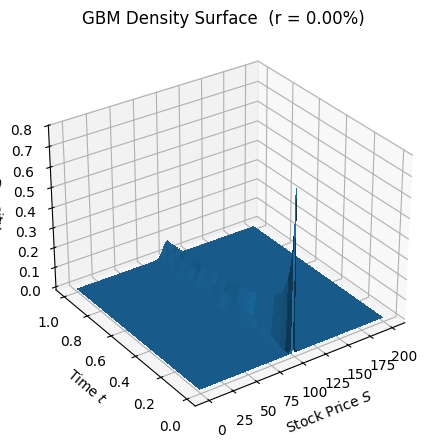

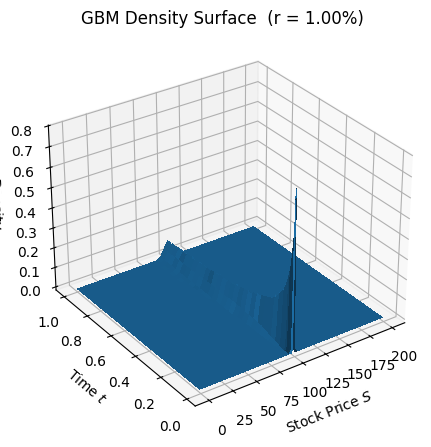

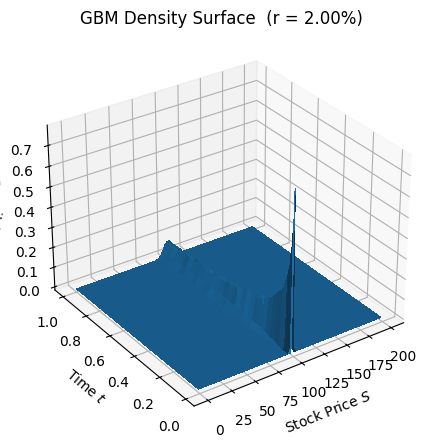

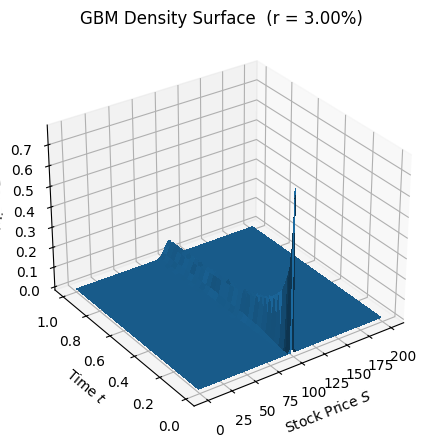

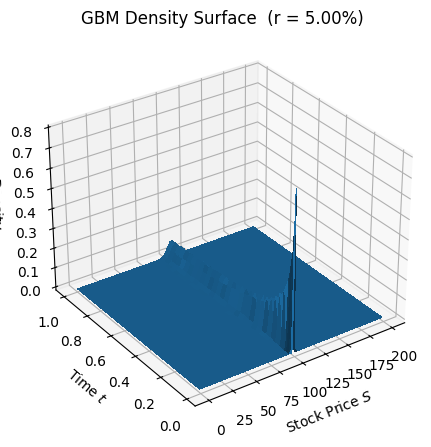

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys, os

FNAME = "gbm_density_hist_3d.npz"

data      = np.load(FNAME)
t_list    = data["t_list"]
r_grid    = data["r_grid"]
S_centers = data["S_centers"]
density   = data["density"]

S_mesh, T_mesh = np.meshgrid(S_centers, t_list, indexing="xy")

for j, r_val in enumerate(r_grid):
    Z = density[:, j, :]

    fig = plt.figure(figsize=(6, 4.5))
    ax  = fig.add_subplot(111, projection="3d")

    ax.plot_surface(S_mesh, T_mesh, Z, linewidth=0, antialiased=False)

    ax.set_xlabel("Stock Price $S$")
    ax.set_ylabel("Time $t$")
    ax.set_zlabel("Density")
    ax.set_title(f"GBM Density Surface  (r = {r_val:.2%})")

    ax.view_init(elev=30, azim=235)
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
import tqdm, random

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(20240617)
np.random.seed(20240617)
random.seed(20240617)

HIDDEN       = 64
N_EPOCH_REF  = 2000
LR           = 1e-2
K_GAUSS      = 10

d         = np.load("gbm_density_hist_3d.npz")
t_list    = torch.tensor(d["t_list"],    dtype=torch.float32)
r_grid    = torch.tensor(d["r_grid"],    dtype=torch.float32)
S_grid    = torch.tensor(d["S_centers"], dtype=torch.float32)
pdf_ref   = torch.tensor(d["density"],   dtype=torch.float32)

N_t, N_r, N_S = pdf_ref.shape
bin_w = float(S_grid[1] - S_grid[0])

class SliceMDN(nn.Module):
    def __init__(self, hidden=HIDDEN, n_layers=3, K=K_GAUSS):
        super().__init__()
        layers = [nn.Linear(2, hidden), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        self.body = nn.Sequential(*layers)

        self.out_mu  = nn.Linear(hidden, K)
        self.out_log = nn.Linear(hidden, K)
        self.out_pi  = nn.Linear(hidden, K)

    def forward(self, S_in, r_in):
        h = self.body(torch.cat([S_in, r_in], dim=1))
        mu    = self.out_mu(h)
        sigma = torch.exp(self.out_log(h))
        pi    = torch.softmax(self.out_pi(h), dim=1)
        return mu, sigma, pi

    def pdf(self, S_q, r_q):
        mu, sigma, pi = self.forward(S_q, r_q)
        probs = torch.distributions.Normal(mu, sigma).log_prob(S_q).exp()
        return (pi * probs).sum(dim=1, keepdim=True)

def mdn_loss(model, S_b, R_b, p_tar):
    p_pred = model.pdf(S_b, R_b)
    return (p_pred - p_tar).pow(2).mean()

models = nn.ModuleList([SliceMDN() for _ in range(N_t)]).to(device)

S_b = S_grid.unsqueeze(1).to(device)

for i_t, model in enumerate(models):
    opt = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, N_EPOCH_REF + 1):
        loss = 0.
        for j_r, r_val in enumerate(r_grid):
            R_b   = r_val.repeat(N_S, 1)
            p_ref = pdf_ref[i_t, j_r].unsqueeze(1).to(device)
            loss += mdn_loss(model, S_b, R_b, p_ref)
        loss /= N_r

        opt.zero_grad(); loss.backward(); opt.step()

        if epoch % 500 == 0:
            tqdm.tqdm.write(f"[t={float(t_list[i_t]):.3f}] epoch {epoch}  loss={loss.item():.4e}")

    if i_t < N_t - 1:
        models[i_t + 1].load_state_dict(model.state_dict())

out_dir = Path("slice_mdns_r")
out_dir.mkdir(exist_ok=True)
for t, mdl in zip(t_list, models):
    torch.save(mdl.state_dict(), out_dir / f"mdn_t{float(t):.3f}.pt")
print("All slice-MDNs saved to ./slice_mdns_r/")


[t=0.010] epoch 500  loss=2.7828e-03
[t=0.010] epoch 1000  loss=2.7826e-03
[t=0.010] epoch 1500  loss=2.7823e-03
[t=0.010] epoch 2000  loss=2.7818e-03
[t=0.015] epoch 500  loss=2.3447e-06
[t=0.015] epoch 1000  loss=2.3447e-06
[t=0.015] epoch 1500  loss=2.3481e-06
[t=0.015] epoch 2000  loss=2.3451e-06
[t=0.020] epoch 500  loss=2.9445e-06
[t=0.020] epoch 1000  loss=2.9445e-06
[t=0.020] epoch 1500  loss=3.6427e-06
[t=0.020] epoch 2000  loss=4.3551e-06
[t=0.025] epoch 500  loss=2.9858e-06
[t=0.025] epoch 1000  loss=2.9859e-06
[t=0.025] epoch 1500  loss=1.0281e-05
[t=0.025] epoch 2000  loss=3.8018e-06
[t=0.030] epoch 500  loss=3.2624e-06
[t=0.030] epoch 1000  loss=3.2624e-06
[t=0.030] epoch 1500  loss=3.9600e-06
[t=0.030] epoch 2000  loss=3.2857e-06
[t=0.035] epoch 500  loss=3.3792e-06
[t=0.035] epoch 1000  loss=3.3793e-06
[t=0.035] epoch 1500  loss=1.0491e-05
[t=0.035] epoch 2000  loss=3.8292e-06
[t=0.040] epoch 500  loss=3.5214e-06
[t=0.040] epoch 1000  loss=3.5214e-06
[t=0.040] epoch 150

Visualising model output at fixed r = 0.0200


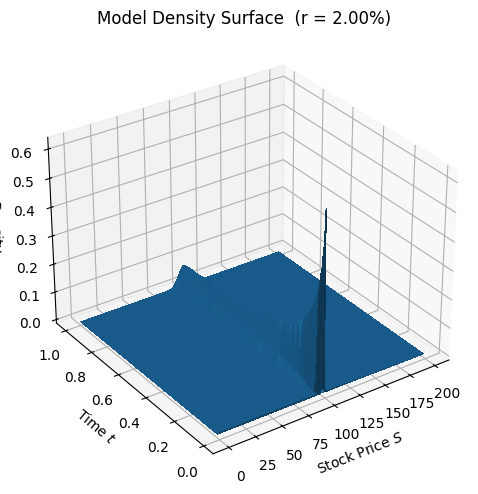

In [5]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


DATA_FPATH   = "gbm_density_hist_3d.npz"
MODEL_DIR    = "slice_mdns_r"

try:
    data = np.load(DATA_FPATH)
except FileNotFoundError:
    print(f"'{DATA_FPATH}' not found. Make sure you ran the density script.")
    raise SystemExit

t_list    = data["t_list"]
r_grid    = data["r_grid"]
S_centers = data["S_centers"]

N_t, N_S  = len(t_list), len(S_centers)

r_idx = len(r_grid)//2
r_val = float(r_grid[r_idx])
print(f"Visualising model output at fixed r = {r_val:.4f}")


HIDDEN, K_GAUSS = 64, 10
class SliceMDN(nn.Module):
    def __init__(self, hidden=HIDDEN, n_layers=3, K=K_GAUSS):
        super().__init__()
        layers = [nn.Linear(2, hidden), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        self.body = nn.Sequential(*layers)

        self.out_mu  = nn.Linear(hidden, K)
        self.out_log = nn.Linear(hidden, K)
        self.out_pi  = nn.Linear(hidden, K)

    def forward(self, S_in, r_in):
        h = self.body(torch.cat([S_in, r_in], dim=1))
        mu     = self.out_mu(h)
        sigma  = torch.exp(self.out_log(h))
        pi     = torch.softmax(self.out_pi(h), dim=1)
        return mu, sigma, pi

    def pdf(self, S_q, r_q):
        mu, sigma, pi = self.forward(S_q, r_q)
        probs = torch.distributions.Normal(mu, sigma).log_prob(S_q).exp()
        return (pi * probs).sum(dim=1, keepdim=True)

device = "cpu"
S_tensor = torch.tensor(S_centers, dtype=torch.float32).unsqueeze(1)
R_tensor = torch.full_like(S_tensor, r_val)

density_pred = np.empty((N_t, N_S), dtype=np.float32)

for i, t in enumerate(t_list):
    model_path = f"{MODEL_DIR}/mdn_t{float(t):.3f}.pt"
    mdl = SliceMDN().to(device)
    mdl.load_state_dict(torch.load(model_path, map_location=device))
    mdl.eval()

    with torch.no_grad():
        p = mdl.pdf(S_tensor, R_tensor)
    density_pred[i] = p.squeeze().cpu().numpy()


S_mesh, T_mesh = np.meshgrid(S_centers, t_list, indexing="xy")

fig = plt.figure(figsize=(6.5, 5))
ax  = fig.add_subplot(111, projection="3d")
ax.plot_surface(S_mesh, T_mesh, density_pred, linewidth=0, antialiased=False)

ax.set_xlabel("Stock Price $S$")
ax.set_ylabel("Time $t$")
ax.set_zlabel("Density")
ax.set_title(f"Model Density Surface  (r = {r_val:.2%})")

ax.view_init(elev=30, azim=235)
plt.tight_layout()
plt.show()


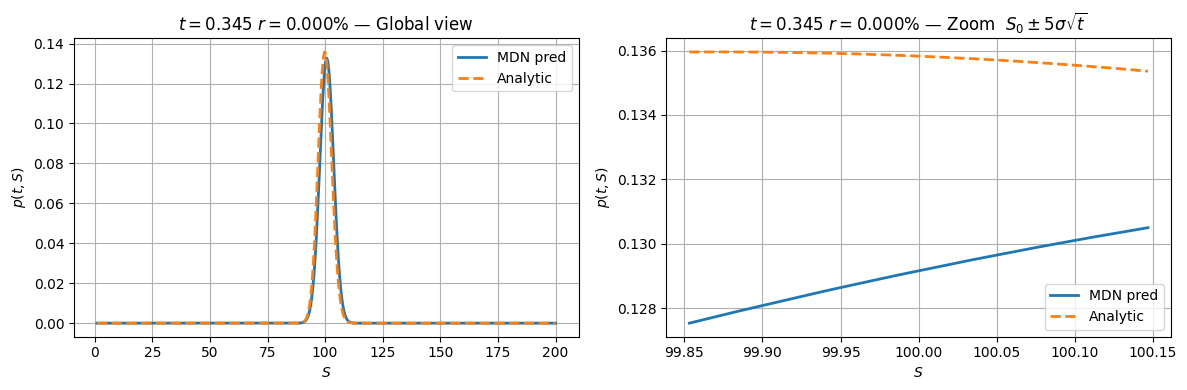

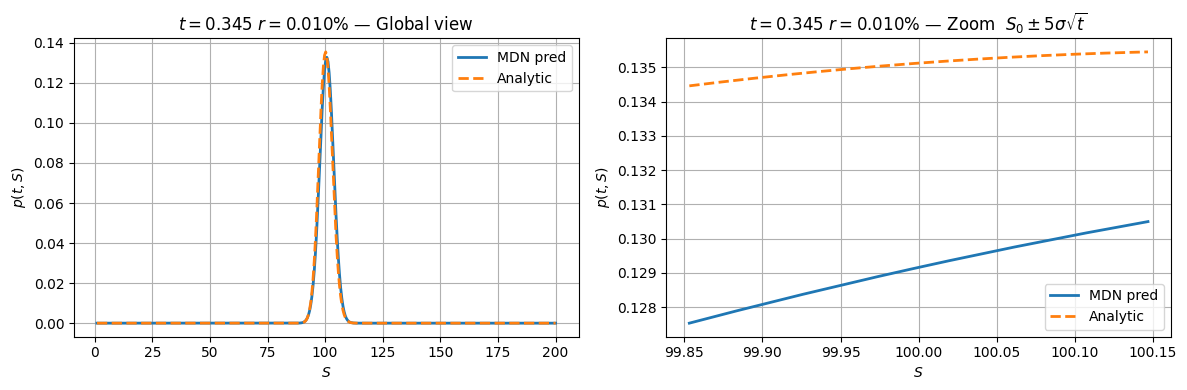

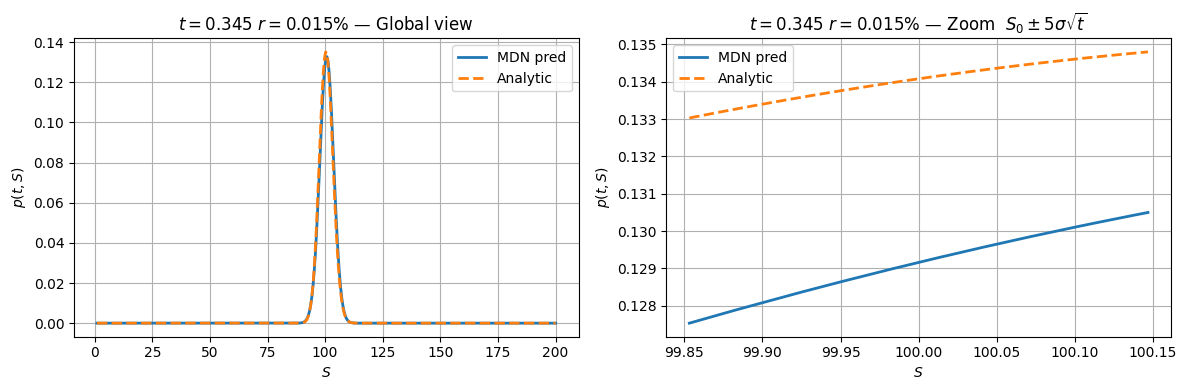

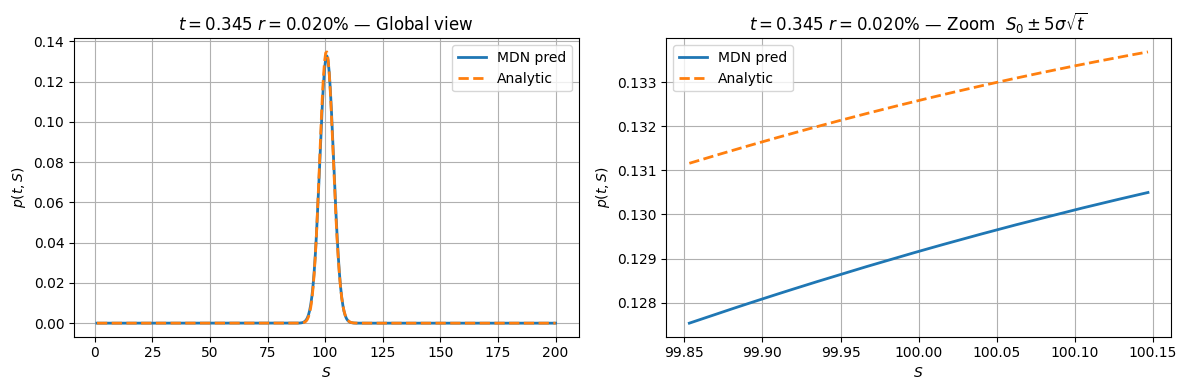

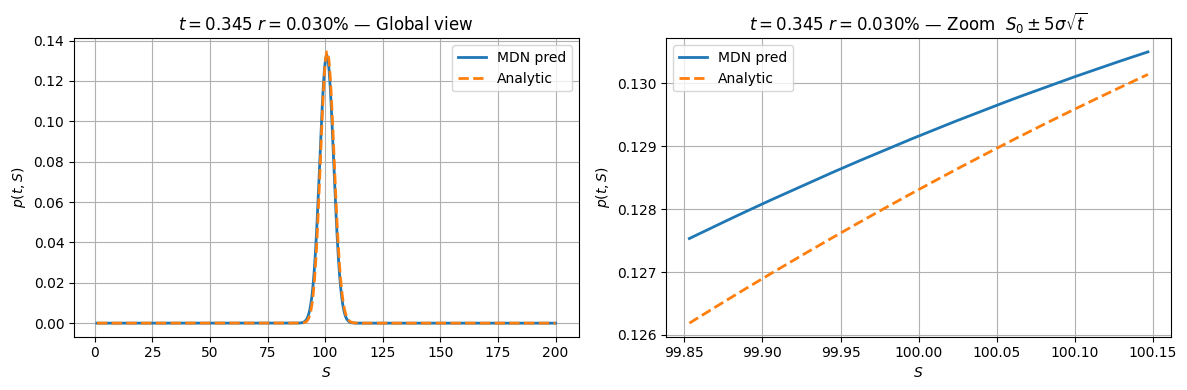

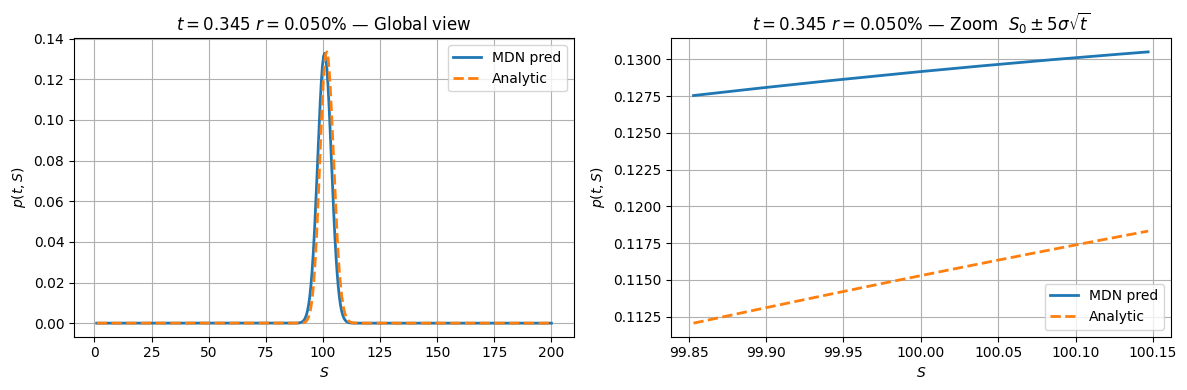

In [14]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path

device   = "cpu"
t_fixed  = 0.345
MODEL_DIR = "slice_mdns_r"

d = np.load("gbm_density_hist_3d.npz")
r_grid = np.array([0.00, 0.01, 0.015, 0.02, 0.03, 0.05], dtype=np.float32)
S_grid    = d["S_centers"]
S0, sigma = 100.0, 0.05

HIDDEN, N_LAYERS, K_GAUSS = 64, 3, 10
class SliceMDN(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(2, HIDDEN), nn.Tanh()]
        for _ in range(N_LAYERS - 1):
            layers += [nn.Linear(HIDDEN, HIDDEN), nn.Tanh()]
        self.body = nn.Sequential(*layers)
        self.out_mu  = nn.Linear(HIDDEN, K_GAUSS)
        self.out_log = nn.Linear(HIDDEN, K_GAUSS)
        self.out_pi  = nn.Linear(HIDDEN, K_GAUSS)
    def forward(self, S_in, r_in):
        h = self.body(torch.cat([S_in, r_in], dim=1))
        mu, sigma, pi = self.out_mu(h), torch.exp(self.out_log(h)), torch.softmax(self.out_pi(h), dim=1)
        return mu, sigma, pi
    def pdf(self, S_q, r_q):
        mu, sigma, pi = self(S_q, r_q)
        probs = torch.distributions.Normal(mu, sigma).log_prob(S_q).exp()
        return (pi * probs).sum(dim=1, keepdim=True)

def gbm_density(t, S, S0=100., r=0.02, sigma=0.05):
    var  = sigma**2 * t
    coef = 1.0 / (S * np.sqrt(2*np.pi*var))
    expo = - (np.log(S/S0) - (r-0.5*sigma**2)*t)**2 / (2*var)
    return coef * np.exp(expo)

ckpt = Path(MODEL_DIR) / f"mdn_t{t_fixed:.3f}.pt"
mdl = SliceMDN().to(device)
mdl.load_state_dict(torch.load(ckpt, map_location=device))
mdl.eval()

S_coarse = np.linspace(1, 200, 400)
width    = 5 * sigma * np.sqrt(t_fixed)
S_fine   = np.linspace(S0 - width, S0 + width, 2000)

for r_val in r_grid:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    for ax, S_plot, tag in [
        (ax1, S_coarse, "Global view"),
        (ax2, S_fine,   f"Zoom  $S_0 \\pm 5\\sigma\\sqrt{{t}}$")
    ]:
        S_tensor = torch.tensor(S_plot, dtype=torch.float32).unsqueeze(1)
        r_tensor = torch.full_like(S_tensor, r_val)

        with torch.no_grad():
            p_pred = mdl.pdf(S_tensor, r_tensor).cpu().numpy().squeeze()
        p_true = gbm_density(t_fixed, S_plot, S0=S0, r=float(r_val), sigma=sigma)

        ax.plot(S_plot, p_pred, label="MDN pred", lw=2)
        ax.plot(S_plot, p_true, "--", label="Analytic", lw=2)
        ax.set_xlabel("$S$")
        ax.set_ylabel("$p(t,S)$")
        ax.set_title(f"$t={t_fixed}$ $r={r_val:.3f}\\%$ — {tag}")
        ax.grid(True); ax.legend()

    plt.tight_layout()
    plt.show()
